In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json
# import plotly.graph_objects as go
import plotly.express as px

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# import spacy

import time
import string


# from sklearn.

# MODELS
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# EVALUATION METRICS and TOOLS
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report


# OTHER TOOLS
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  HalvingGridSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from utils import main as utils, plots, preprocessing


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alhas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Needed functions

In [2]:

with open("data/id_to_label.json", "r") as f:
    # Write the dictionary to the file in JSON format
    id_to_label = json.load(f)

In [3]:
def plot_feature_effects(clf, 
                         X_train,
                         feature_names,
                         target_names,
                         to_labels=False,
                         top_k=5,
                         verbose=False):
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    target_names = np.sort(target_names)
    if to_labels:
        target_names = [id_to_label[i] for i in target_names]
        
    fig, ax = plt.subplots(figsize=(10, 8))

    # Get top k features for each target class
    for i, label in enumerate(target_names):
        # if len(average_feature_effects) > 1:
        #     print(i, 'label', label, average_feature_effects)
        top_indices = np.argsort(average_feature_effects[i if len(average_feature_effects) > 1 else 0])[::-1][:top_k]
        top_k_words = feature_names[top_indices]
        top_k_effects = average_feature_effects[i if len(average_feature_effects) > 1 else 0, top_indices]
        ax.barh(top_k_words, top_k_effects, label=label, alpha=0.5)

    ax.set_xlabel('Average Feature Effects')
    ax.legend()
    ax.set_title(f'Top {top_k} Feature Effects per Target Class')

    if verbose:
        # Display top k keywords for each class in a table
        top_k_keywords = pd.DataFrame()
        for i, label in enumerate(target_names):
            top_indices = np.argsort(average_feature_effects[i if len(average_feature_effects) > 1 else 0])[::-1][:top_k]
            top_k_words = feature_names[top_indices]
            top_k_keywords[label] = top_k_words
        print(f"Top {top_k} Keywords per Class:\n{top_k_keywords}")
    plt.show()
    return ax

In [4]:
# def plot_feature_effects(clf, X_train, feature_names, target_names, top_n=5):
#     # learned coefficients weighted by frequency of appearance
#     average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

#     # find top n keywords for each label
#     top_keywords = {}
#     for i, label in enumerate(target_names):
#         top_n_indices = np.argsort(average_feature_effects[i])[::-1][:top_n]
#         top_keywords[label] = [(feature_names[idx], round(average_feature_effects[i, idx], 3)) for idx in top_n_indices]

#     # create a horizontal bar chart for each label
#     fig, axs = plt.subplots(nrows=len(target_names), figsize=(12, 8))
#     for i, label in enumerate(target_names):
#         keywords, importance = zip(*top_keywords[label])
#         axs[i].barh(keywords, importance, color='tab:blue')
#         axs[i].set_xlim(left=-1, right=1)
#         axs[i].set_xlabel('Feature Importance')
#         axs[i].set_title(f'Top {top_n} keywords for {label}')

#     plt.tight_layout()
#     plt.show()


In [10]:
def train_model(model,
                X_train, y_train,
                X_test, y_test,                
                verbose=False):  
        
    if model == 'RF':
        clf = RandomForestClassifier(n_estimators=100)
    # pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=10000))  
    elif model == 'LR':
        clf = LogisticRegression(max_iter=10000)
    elif model == 'KN':
        clf = make_pipeline(StandardScaler(with_mean=False),
             KNeighborsClassifier(n_neighbors=16))

    if verbose:
        print("#"*10, f"Training {clf.__class__.__name__}\n")
    
    clf.fit(X_train, y_train)
    
    
    score = clf.score(X_test, y_test)
    pred = clf.predict(X_test)

    if verbose:
        if cat:
            sns.histplot([f'{id_to_label[i]} ({i})' for i in df['ocms']])
            plt.xticks(rotation=90)
            plt.show()
            
        print("#"*10, score)
    
    
    return clf, pred, score

In [14]:
def run(models=['LR', 'RF', 'KN'], **kwargs):
    # for cat in categories:
# for cat in [224, 226]:
    # print(cat)
    
    exact = kwargs.get('exact') and kwargs.get('specific_cat')
    
    # Load data
    df, X_train, X_test, y_train, y_test, feature_names, target_names = utils.load_dataset('data/en_data.csv',
                                                                                           target_label='ocms',
                                                                                           exact=exact,
                                                                                           **kwargs)
    # Run models
    for model in models:
        print('#'*10, kwargs.get('cat'), model, '\n')
            
        clf, pred, score = train_model(model, 
                                       X_train, y_train,
                                       X_test, y_test,
                                       )
        
        plots.make_cm(clf, pred, y_test, target_names, to_labels=id_to_label)
        if model == 'RF':
            # plots.plot_feature_effects(clf, X_train, fn, tn)  
            plots.plot_feature_importance(clf.feature_importances_, feature_names, 'RF')    
        else:
            plot_feature_effects(clf, X_train, feature_names, target_names, to_labels=id_to_label)#, top_k=10)    

# Specific categories

In [35]:
id_to_label['240']

'agriculture'

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


########## None LR 



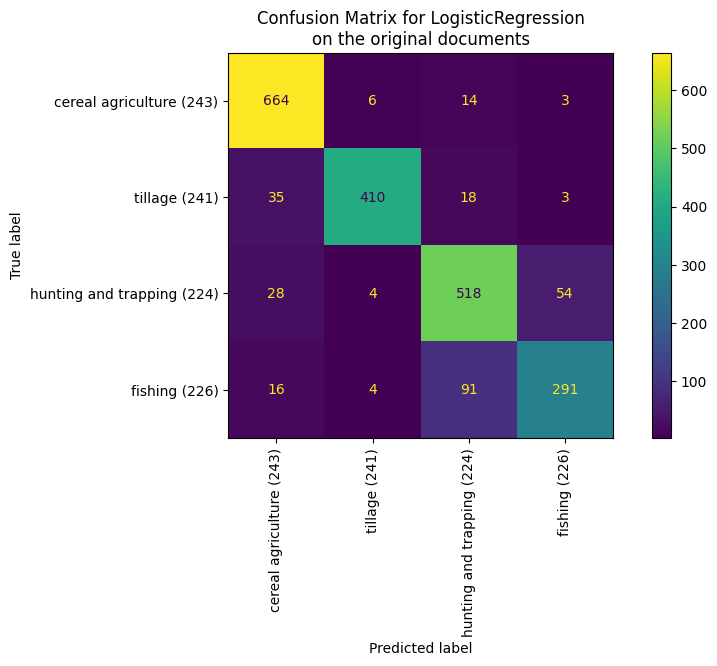

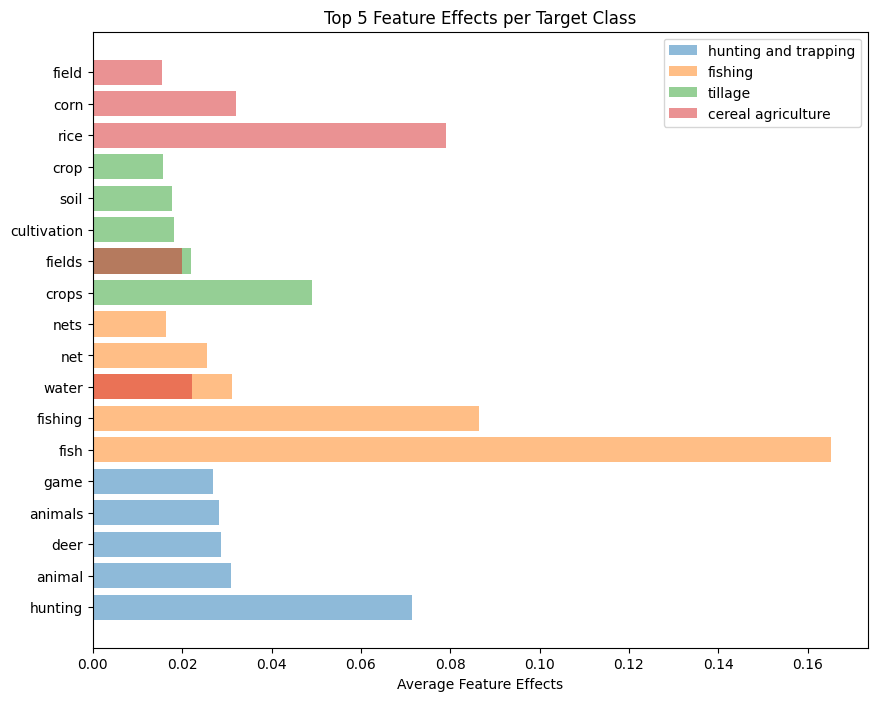

########## None RF 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


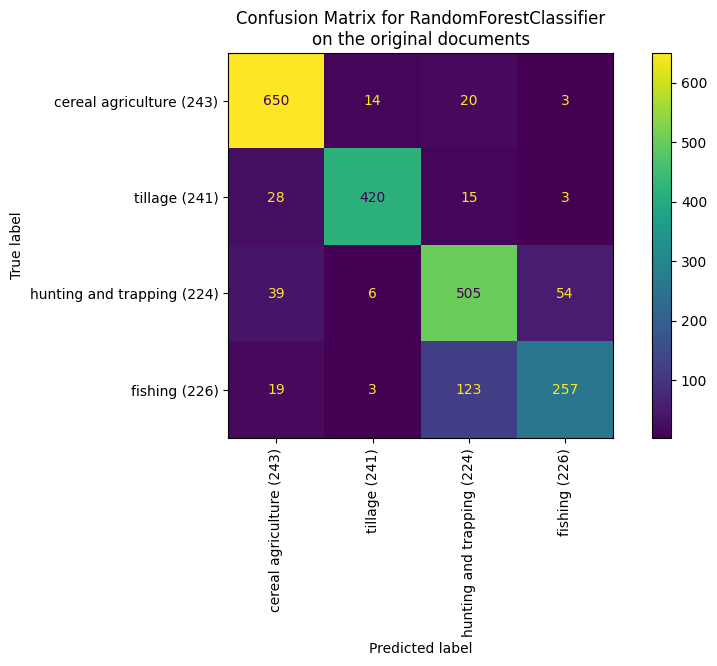

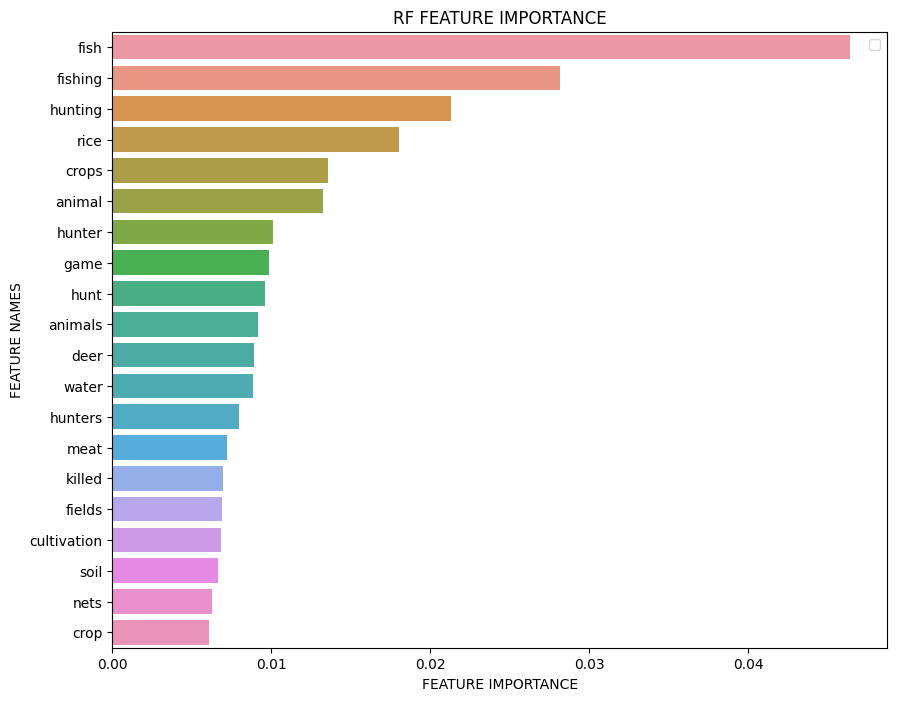

In [15]:
run(models=['LR', 'RF'], chosen_categories=[224, 226, 241, 243])

# Cat vs subcategories (binary classification)

In [ ]:
for i in [224, 226, 241, 243]:
    run(models=['LR', 'RF'], specific_cat=i, exact=True)

# Cat vs subcategories (multi-label classification)

In [ ]:
for i in [224, 226, 241, 243]:
    run(models=['LR', 'RF'], specific_cat=i, exact=False)

# Archive

In [ ]:
data = []
for i in [224, 226, 241, 243]:
    data.append(df[ df['ocms_list'].map(lambda x: len(x) == 1 and x[0] == i) ])
data = pd.concat(data)

In [ ]:
sns.histplot(data['ocms'])
# data.ocms.hist()

In [ ]:
s = time.time()

tfidf_vec = TfidfVectorizer(min_df=3, # If a token appears fewer times than this, across all documents, it will be ignored
                             # tokenizer=nltk.word_tokenize, # we use the nltk tokenizer
                             tokenizer=preprocessing.tokenize_data, # we use the custom tokenizer
                             stop_words='english')#stopwords.words('english')) # stopwords are removed

tfidf_text = tfidf_vec.fit_transform(data['textrecord'])


e = time.time()
print("Elapsed time during the whole program in seconds:",
                                         e-s) 

## Random Forest

In [ ]:
# clf = RandomForestClassifier(random_state=0)
# # cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

# param_grid = {"max_depth": [3, None],
#               "min_samples_split": [5, 10],}

# search = HalvingGridSearchCV(clf, param_grid, resource='n_estimators',
#                              max_resources=10,
#                              cv=5,
#                              random_state=0).fit(X_train, y_train)
# search.best_params_  # {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 9}

In [ ]:
# search.best_estimator_.score(X_test, y_test)

In [ ]:
# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

In [ ]:
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

# n_scores = cross_val_score(model, 
#                            tfidf_text, data['parent_ocms'], 
#                            scoring='accuracy', 
#                            cv=cv, 
#                            n_jobs=-1, 
#                            error_score='raise')

In [ ]:

# print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
# Evaluate the model on the testing set
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

In [ ]:
preds = model.predict(X_test)
print(preds)

In [ ]:
plots.make_cm(model, preds, y_test, data['ocms'].uniqueque())

In [ ]:
report = classification_report(y_test, preds, digits = 3)
print(report)

In [ ]:
_test = df['textrecord'][SELECTED*2:SELECTED*3]
_test = text_vec.transform(_test)

In [ ]:
rf.predict(_test)[100:300]

In [ ]:
# Evaluate the model on the testing set
accuracy = rf.score(X_test, y_test)
print("Accuracy:", accuracy)

## Logisitc Regression

In [ ]:

pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=10000))

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_text, data['parent_ocms'], test_size=0.2)

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
pipe.score(X_test, y_test)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
clf.predict(X[:2, :])

In [ ]:
clf.predict_proba(X[:2, :]).shape

## KNN

In [ ]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X_train)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y_train, cv=5)
    scores.append(np.mean(score))

In [ ]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [ ]:
pipe = make_pipeline(StandardScaler(with_mean=False),
                     KNeighborsClassifier(n_neighbors=16))

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
pipe.score(X_test, y_test)

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Define a function to preprocess a text record
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc 
              if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-']
    return tokens

In [ ]:
s = time.time()

# Apply the preprocess_text function to the textrecord column
df["processed_text"] = df["textrecord"].apply(preprocess_text)

    
e = time.time()


print("Elapsed time during the whole program in seconds:",
                                         e-s) 

In [ ]:
df.to_csv('data/splitted_preprocessed.csv')

In [ ]:
s = time.time()

nlp.pipe(df["textrecord"])


e = time.time()


print("Elapsed time during the whole program in seconds:",
                                         e-s) 

In [ ]:
# Preprocess data (e.g., remove missing values, encode categorical variables)

for doc in nlp.pipe(texts):
    # Do something with the doc here
    print([(ent.text, ent.label_) for ent in doc.ents])

    

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop("dependency_strength", axis=1), data["dependency_strength"], test_size=0.2)

In [ ]:
# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the testing set
accuracy = rf.score(X_test, y_test)
print("Accuracy:", accuracy)

# Links
- https://www.datacamp.com/tutorial/random-forests-classifier-python
- https://machinelearningmastery.com/random-forest-ensemble-in-python/
- https://github.com/WillKoehrsen/Data-Analysis/tree/master/random_forest_explained
- https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
- https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
- **GREAT RESOURCE** https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
- https://scikit-learn.org/stable/modules/ensemble.html#subsampling